# Figure 1 a

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import pandas as pd
import util
import classify_tss
import glob, os
from tqdm import tqdm
import re
import numpy as np
import matplotlib as mpl

/home/shush/miniconda3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [9]:
genome_path = '/shared/shush/genomes/hg19.fa'
fasta_extractor = util.FastaStringExtractor(genome_path)
model_path = 'https://tfhub.dev/deepmind/enformer/1'
result_path = '/shared/shush/results/CREME/'
tss_df = pd.read_csv(f'{result_path}/TSS.csv')
# model = util.Enformer(model_path)
track = 5111


In [10]:
# ordered_list = []
# for p in glob.glob('../CRE_analysis/results//tss_background_shuffle_10/*.csv'):
#     ordered_list.append(p.split('/')[-1])
# filenames = pd.DataFrame(ordered_list)
# filenames.to_csv(f'{result_path}/filenames.csv')

In [26]:
res_summary_path = 'tss_and_background_shuffle_results.csv'
all_res_csvs = glob.glob('/shared/shush/results/CREME/tss_background_shuffle_10/*.csv')

if os.path.isfile(res_summary_path):
    res_summary = pd.read_csv(res_summary_path)
else:
    mean_res = []
    for i, path in tqdm(enumerate(all_res_csvs)):
        res = pd.read_csv(path).mean()

        mean_res.append(res)
    dinuc_not_tss = [m['dinuc_not_tss'] for m in mean_res]
    random_not_tss = [m['random_not_tss'] for m in mean_res]
    res_summary_all = pd.DataFrame({'dinuc': dinuc_not_tss, 
                                'random': random_not_tss
                               }
                              )
    res_summary_all['path'] = [int(a.split('/')[-1].split('.')[0] )for a in all_res_csvs]
    res_summary = res_summary_all.merge(tss_df, left_on='path', right_on='Unnamed: 0')
    res_summary = res_summary.drop_duplicates(subset=['gene'])
    res_summary.to_csv(res_summary_path, index=None)

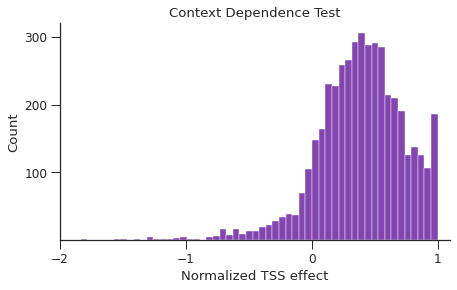

In [23]:
sns.set(font_scale = 1.1)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

fig = plt.figure(figsize=[7, 4])
ax = sns.histplot(data=res_summary, x='dinuc', color='#5A0896')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Normalized TSS effect') # (WT - M) / WT
plt.xlim([-2,1.1])
plt.xticks([-2, -1, 0, 1])
plt.yticks([100, 200, 300])
plt.title('Context Dependence Test')
fig.savefig('TSS_context_effect_hist.pdf', format='pdf', dpi=300, bbox_inches='tight')


In [24]:
threshold_upper_weak = 0.95
threshold_lower = -0.5
delta_diff_from_0 = 0.2
dfs = [res_summary[(res_summary['dinuc'] > threshold_upper_weak) & (res_summary['random'] > threshold_upper_weak)],
         res_summary[(res_summary['dinuc'] < threshold_lower) & (res_summary['random'] < threshold_lower)],
         res_summary[
             (np.abs(res_summary['dinuc']) < delta_diff_from_0) & (np.abs(res_summary['random']) < delta_diff_from_0)]]

labeled = []

for label, df in zip(['enhancers', 'repressors', 'neutral'], dfs):
    df['label'] = f'{label} N={df.shape[0]}'
    labeled.append(df)
labeled = pd.concat(labeled)

/tmp/ipykernel_3868141/1301156438.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = f'{label} N={df.shape[0]}'
/tmp/ipykernel_3868141/1301156438.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = f'{label} N={df.shape[0]}'
/tmp/ipykernel_3868141/1301156438.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [25]:
labeled = labeled[['dinuc', 'label', 'path']].rename(columns={'path': 'TSS_index'})
labeled.merge(tss_df, left_on='TSS_index', right_on='Unnamed: 0').to_csv('cre_search_regions.csv')
for c, df in labeled.merge(tss_df, left_on='TSS_index', right_on='Unnamed: 0').groupby('label'):
    df[['gene']].to_csv(f'{c.split()[0]}.csv')
    
grouped_res = res_summary.merge(labeled, how='outer')

labeled = labeled.rename(columns={'label': 'context'})
labeled['context'].unique()

array(['enhancers N=152', 'repressors N=11', 'neutral N=40'], dtype=object)

In [27]:
labeled.to_csv('labelled.csv', index=None)

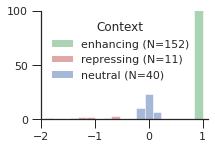

In [28]:
# ax = sns.histplot(data=grouped_res, x='dinuc', hue='label', palette=['#F1E5F5', '#09EF1E', '#F60B04', '#0726C0'], alpha=0.5, bins=10)
fig = plt.figure(figsize=[3, 2])
sns.set(font_scale = 1.)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

ax = sns.histplot(data=labeled, x='dinuc', hue='context', palette=['g', 'r', 'b'])


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.legend(frameon=False);
legend = ax.get_legend()
handles = legend.legendHandles
legend.remove()
ax.legend(handles, ['enhancing (N=152)','repressing (N=11)',  'neutral (N=40)'], title='Context', frameon=False)


plt.xlabel('')
plt.ylabel('')

plt.title('')
plt.ylim(0,100)
plt.xlim([-2,1.1])
plt.yticks([0,50,100])
fig.savefig('TSS_context_effect_inset.pdf', format='pdf', dpi=300, bbox_inches='tight')


# Figure 1 b

strong


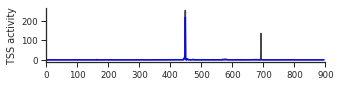

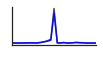

enhancing CRE


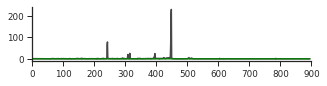

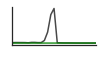

repressing CRE


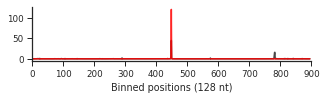

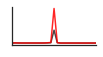

In [20]:

padding = 196608
tile_size = 5000
half_window_around_tss = tile_size // 2

strong_tss_case = np.argwhere((abs(res_summary.iloc[:,0]) < 0.1))[1][0]
pos_CRE_case = np.argwhere((res_summary.iloc[:,0] > 0.99))[0][0]
neg_CRE_case = np.argwhere((res_summary.iloc[:,0] < -1))[0][0]

special_points = {
                 'strong': ('blue', strong_tss_case),
                 'enhancing CRE': ('green', pos_CRE_case),
                 'repressing CRE': ('red', neg_CRE_case),
}


for k, (color, edge_case_index) in special_points.items():
    name = str(k)
    print(k)
    edge_case_index = res_summary['path'][edge_case_index]
    seq = util.get_seq(edge_case_index, tss_df, fasta_extractor)
    seq_center = seq.shape[0] // 2
    input_seq_end = seq.shape[0] - padding//2
    input_seq_start = padding // 2
    left_tss_border = seq_center - half_window_around_tss
    right_tss_border = seq_center + half_window_around_tss
    wt_pred = model.predict_on_batch(seq[np.newaxis])['human'][0, :, track]
    all_except_tss_shuffled_seq = classify_tss.shuffle_seq_mixing_regions(seq, [[input_seq_start, left_tss_border], [right_tss_border, input_seq_end]], 'dinuc')
    preds = [util.predict(model, all_except_tss_shuffled_seq) for _ in range(5)]
    for zoom in [None, [425, 475]]:
        if zoom:
            fig = plt.figure(figsize=[1.5, .7])
            name = name + '_zoom'
        else:
            fig = plt.figure(figsize=[5, 1])
            
        sns.set(font_scale = .8)

        sns.set_style(style='white')
        plt.rcParams['xtick.major.size'] = 5
        plt.rcParams['xtick.major.width'] = 1

        plt.rcParams['ytick.major.size'] = 5
        plt.rcParams['ytick.major.width'] = 1
        plt.rcParams['xtick.bottom'] = True
        plt.rcParams['ytick.left'] = True

        plt.plot(wt_pred, 'k', alpha=0.8)
        plt.plot(np.concatenate(preds).mean(axis=0), color=color, alpha=0.85)
        plt.xlim(0, 900)
        
        if zoom is None:
            if k == 'strong':
                plt.ylabel('TSS activity')
            if k == 'repressing CRE':
                plt.xlabel('Binned positions (128 nt)')
                
        if zoom:
            sns.set(font_scale = .8)
            plt.xticks([])
            plt.yticks([])
            plt.xlim(435, 461)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.show()
        
        fig.savefig(name+'.pdf', format='pdf', dpi=300, bbox_inches='tight')


# Figure 1 c

In [29]:
labeled.shape

(203, 3)

In [30]:
unique_ids = labeled['TSS_index'].values
unique_ids.shape

(203,)

In [48]:
res_path = f'{result_path}/GIA_full/'
test_result_path = f'{res_path}/every_TSS_everywhere.csv'
if not os.path.isfile(test_result_path):
    compiled_results = pd.concat([pd.read_csv(f).iloc[:,1:] for f in filtered_csvs])
    compiled_results.reset_index().to_csv(test_result_path, index=None)
else:
    compiled_results = pd.read_csv(test_result_path).reset_index()

In [49]:
compiled_results.shape

(453299, 6)

In [50]:
compiled_results['background_id'] = [b.split('/')[-1].split('.')[0].split('_')[-1] for b in compiled_results['backgrounds_seq_path']]

In [51]:
# mask = []
# for _, row in tqdm(compiled_results.iterrows()):
#     if int(row['background_id']) in unique_ids and int(row['insert_ids'].split('_')[-1]) in unique_ids:
#         mask.append(True)
#     else:
#         mask.append(False)
        
# compiled_results = compiled_results[mask]


In [52]:
mask = [True if 'rshuffle' not in c else False for c in compiled_results['background_shuffle_mode']]
compiled_results = compiled_results[mask]
compiled_results.shape

(453299, 7)

In [53]:
neg_control = pd.read_csv(f'{res_path}/just_background.csv')
neg_control[neg_control['background_shuffle_mode']=='complete_dishuffles']['TSS_signal'].max()

1.5684919357299805

In [54]:
positive_control = pd.read_csv(f'{res_path}/TSS_reinsert_into_same_seq.csv')


mask = [True if 'rshuffle' not in c else False for c in positive_control['background_shuffle_mode']]

positive_control = positive_control[mask]

In [55]:
res = {}
shuffle_converter = {'no_tss_dishuffles': 'dinuc',
                      'original': 'original'}
labels = ['positive_control', 'test']
for d, df in enumerate([positive_control, compiled_results]):
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])

    df['background_id'] = [b.split('/')[-1].split('.')[0] for b in df['backgrounds_seq_path']]
    df = df.drop(columns=['backgrounds_seq_path'])

    mean_df = df.groupby(['background_shuffle_mode', 'insert_ids', 'background_id']).mean().reset_index()
    mean_df['background_shuffle_mode'] = [shuffle_converter[m] for m in mean_df['background_shuffle_mode'].values]
    res[labels[d]] = mean_df
    

In [56]:


mask = []
for _, row in tqdm(res['positive_control'].iterrows()):
    if int(row['background_id'].split('_')[-1]) in unique_ids and int(row['insert_ids'].split('_')[-1]) in unique_ids:
        mask.append(True)
    else:
        mask.append(False)
        
res['positive_control'] = res['positive_control'][mask]

708it [00:00, 16141.06it/s]


In [57]:
df_control = res['positive_control']
df_control = df_control[df_control['background_shuffle_mode']=='original']

In [58]:
N = labeled.shape[0]
assert res['test'].shape[0] == N * N * 2 # n backgrounds * n TSSs *  n shuffle types
assert df_control.shape[0] == N * 1 * 1 # n backgrounds * n shuffle types * n TSSs


In [59]:
merged_dfs = []
for shuffle_mode in ['original', 'dinuc']: # original or dinuc
    print(shuffle_mode)
    df = res['test']
    df = df[df['background_shuffle_mode']==shuffle_mode]
    df['background class'] = [b.split('_')[0] for b in df['background_id']]
    df['tss class'] = [b.split('_')[1] for b in df['insert_ids']]
    # filter positive control rows for shuffle mode 

    df_control['control class'] = [b.split('_')[0] for b in df_control['background_id']]
    merged_df = df.merge(df_control, on='insert_ids', suffixes=[' test', ' control'])
#     merged_df = merged_df[['tss class', 'background class', 'TSS signal test', 'TSS signal control']]
    merged_df['fold change over control'] = merged_df['TSS signal test'] / merged_df['TSS signal control']
    merged_df = merged_df[(merged_df['background class']!='dinuc') & (merged_df['tss class']!='dinuc')]
    merged_df['shuffle mode'] = shuffle_mode
    merged_dfs.append(merged_df)
    
merged_dfs = pd.concat(merged_dfs)
    

original
dinuc


/tmp/ipykernel_3868141/272229269.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['background class'] = [b.split('_')[0] for b in df['background_id']]
/tmp/ipykernel_3868141/272229269.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tss class'] = [b.split('_')[1] for b in df['insert_ids']]
/tmp/ipykernel_3868141/272229269.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [60]:
merged_dfs.head(2)

,background_shuffle_mode test,insert_ids,background_id test,level_0,index,TSS signal test,background class,tss class,background_shuffle_mode control,background_id control,TSS signal control,control class,fold change over control,shuffle mode
0,original,194108_enhancing_101192,enhancing_101192,274118.0,0.0,175.74559,enhancing,enhancing,original,enhancing_101192,175.74559,enhancing,1.000000,original
1,original,194108_enhancing_101192,enhancing_101276,314589.0,0.0,196.42766,enhancing,enhancing,original,enhancing_101192,175.74559,enhancing,1.117682,original


In [61]:

mpl.rcParams.update(mpl.rcParamsDefault)

background class
enhancing     23104
neutral        6080
repressing     1672
Name: insert_ids, dtype: int64
background class
enhancing     6080
neutral       1600
repressing     440
Name: insert_ids, dtype: int64
background class
enhancing     1672
neutral        440
repressing     121
Name: insert_ids, dtype: int64


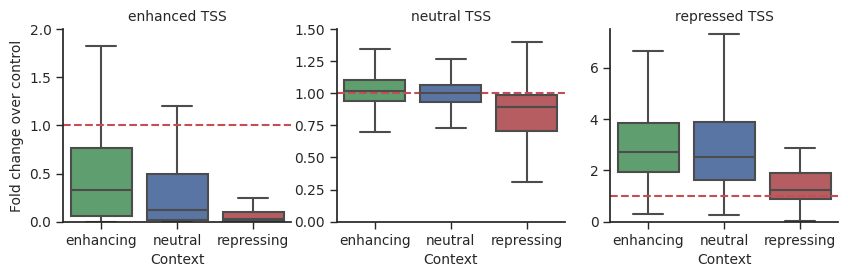

background class
enhancing     23104
neutral        6080
repressing     1672
Name: insert_ids, dtype: int64
background class
enhancing     6080
neutral       1600
repressing     440
Name: insert_ids, dtype: int64
background class
enhancing     1672
neutral        440
repressing     121
Name: insert_ids, dtype: int64


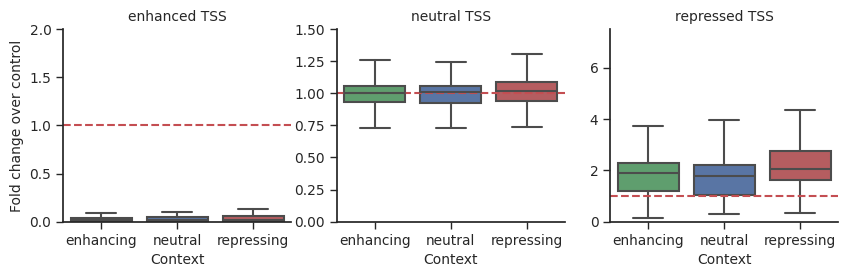

<Figure size 640x480 with 0 Axes>

In [62]:
donor_name = {'enhancing': 'enhanced', 'neutral': 'neutral', 'repressing': 'repressed'}
ylims = [2, 1.5, 7.5]
sns.set(font_scale = .9)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

for shuffle_mode in ['original', 'dinuc']:
    df_per_shuffle = merged_dfs[merged_dfs['shuffle mode']==shuffle_mode]
    fig, axes = plt.subplots(1, 3, sharey=False, figsize=[10, 2.5])
    
    for i, (donor, df) in enumerate(df_per_shuffle.groupby('tss class')):
        ax = axes[i]
#         df['background class'] = [acceptor_name[d] + ' TSS' for d in df['background class']] 
        elements = ['enhancing', 'neutral', 'repressing']
        pvals, pairs = util.get_pvals(elements, df, 'background class', 'fold change over control', 'ks_2samp')
        sns.boxplot(data=df, x='background class', y='fold change over control', 
                    showfliers=False,  
                    palette=['g', 'b', 'r'], ax=ax)
#         ax.set_xlabel('')
        print(df.groupby('background class').count()['insert_ids'])
        if i == 0:
            ax.set_ylabel('Fold change over control', fontsize=10)
        else:
            ax.set_ylabel('')
#         ax.set_ylim(-1, 5)
        
    
        
        x1, x2 = ax.get_xlim()
        ax.set_ylim(0, ylims[i])
        
        ax.hlines(1, x1, x2, color='r', linestyles='--')
        ax.set_title(donor_name[donor]+' TSS', fontsize=10)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('Context', fontsize=10)
        
    plt.show()
    fig.savefig(shuffle_mode+'.pdf', format='pdf', dpi=300, bbox_inches='tight')
    
plt.tight_layout()

In [47]:
df.groupby('background class').count()

,background_shuffle_mode test,insert_ids,background_id test,level_0,index,TSS signal test,tss class,background_shuffle_mode control,background_id control,TSS signal control,control class,fold change over control,shuffle mode
background class,,,,,,,,,,,,,
enhancing,1672,1672,1672,1672,1672,1672,1672,1672,1672,1672,1672,1672,1672
neutral,440,440,440,440,440,440,440,440,440,440,440,440,440
repressing,121,121,121,121,121,121,121,121,121,121,121,121,121
